Leave-one-group-out for the immune response prediction

通过TCR序列相似性和克隆转录基线约束得到克隆型的原型，超越TCR或T cell的pMHC结合预测，构建了实际免疫应答预测的方法

不同患者之间，其T细胞的抗原识别存在共性的可被机器学习模型识别的模式，如相似的motif基序和相似的基因表达所形成的细胞亚型，构建学习模型并训练已有患者的数据、识别免疫应答模式，泛化到新患者，具有极高的临床相关性优势。

In [1]:
import warnings
from anndata import ImplicitModificationWarning
warnings.filterwarnings("ignore", category=ImplicitModificationWarning)
warnings.filterwarnings("ignore")

In [2]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import numpy as np
import scanpy as sc
import vqtcr as vq

In [3]:
path_base = '/mnt/d/Dataset/MrTCR/BCC/'
path_data = path_base + 'scc_merged_airr.h5ad'

In [4]:
vq.set_random_seed(2025)
adata = sc.read_h5ad(path_data)
adata

AnnData object with n_obs × n_vars = 14820 × 5000
    obs: 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'cdr3s_nt', 'cdr3s_aa', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clonotype', 'clonotype_size', 'VJ_1_junction_aa', 'VDJ_1_junction_aa', 'alpha_len', 'beta_len'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'chain_indices', 'clonotype', 'cluster_colors', 'hvg', 'ir_dist_nt_identity', 'log1p', 'patient_colors', 'treatment_colors'
    obsm: 'airr', 'alpha_mask', 'alpha_seq', 'beta_mask', 'beta_seq', 'chain_indices'

In [5]:
adata.obs.cluster.value_counts()

CD8_ex        2562
CD8_mem       2509
Treg          2088
Tfh           1900
Naive         1346
CD8_naive     1227
Th17          1191
CD8_eff        747
CD8_act        707
CD8_ex_act     543
Name: cluster, dtype: int64

In [6]:
adata.obs.patient.value_counts()

su010    5355
su011    4000
su013    3126
su014    2339
Name: patient, dtype: int64

In [7]:
params = vq.get_pred_config(lr=1e-3, latent_dim=64, dropout=0.2, 
                            n_labels=10, num_subspace=32, codewords_per_space=64)
params['epoch'] = 20
params

{'dim_latent': 64,
 'batch_size': 512,
 'lr': 0.001,
 'dropout': 0.2,
 'epoch': 20,
 'early': 10,
 'dataset': '',
 'save_path': '',
 'direction': 'max',
 'weight_decay': 0.0001,
 'loss_weight': [1.0, 1.0, 1.0, 1.0],
 'gex': {'dim_latent': 64, 'act': 'elu', 'norm': True},
 'tcr': {'esm_type': 'facebook/esm2_t6_8M_UR50D',
  'kmer_kernels': [1, 3, 5, 7],
  'dim_latent': 64,
  'dim_emb': 64,
  'num_heads': 8,
  'forward_expansion': 4,
  'dropout': 0.2,
  'num_encoder': 2,
  'num_decoder': 2,
  'mask_rate': 0.15,
  'beta_only': False,
  'esm_tokens': True},
 'fus': {'dim_latent': 64, 'dropout': 0.2, 'film_reg': 1.0},
 'pty': {'dim_latent': 128,
  'num_subspace': 32,
  'codewords_per_space': 64,
  'eps': 1e-05,
  'init_scale': 1.0,
  'ema_decay': 0.99,
  'commitment_beta': 0.25,
  'use_cosine': True,
  'dead_code_interval': 1000,
  'dead_code_threshold': 0.0001,
  'dead_code_topk': 16,
  'diversity_weight': 0.001},
 'pred': {'dim_latent': 64, 'dropout': 0.2, 'n_labels': 10}}

Leave one donor out(LoDonor) TCR-pMHC binding prediction

pretrain on all donors

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


warmup codebook:   0%|          | 0/10 [00:00<?, ?it/s]

1.5180284976959229 3.5314619541168213 0.6799658536911011
1.3009837865829468 3.3447351455688477 0.6793107986450195
0.6052905917167664 3.244699478149414 0.5934807658195496
0.4467783570289612 3.121548891067505 0.526104211807251
0.3668171763420105 2.9959194660186768 0.4661492705345154
0.30817997455596924 2.853119373321533 0.40987473726272583
0.30291175842285156 2.6652092933654785 0.3571404218673706
0.24124830961227417 2.564511775970459 0.30846506357192993
0.21220237016677856 2.460885524749756 0.2636876106262207
0.20633424818515778 2.272045135498047 0.22306230664253235
0.19661732017993927 2.199028730392456 0.18761509656906128
0.1842019259929657 2.18203067779541 0.15752515196800232
0.17529544234275818 2.093836784362793 0.13212141394615173
0.1623610109090805 2.1456856727600098 0.1106991171836853
0.16386669874191284 2.091287136077881 0.09280580282211304
0.15876656770706177 2.034635305404663 0.07788968086242676
0.15555286407470703 2.0779318809509277 0.0655464306473732
0.15465986728668213 2.0843

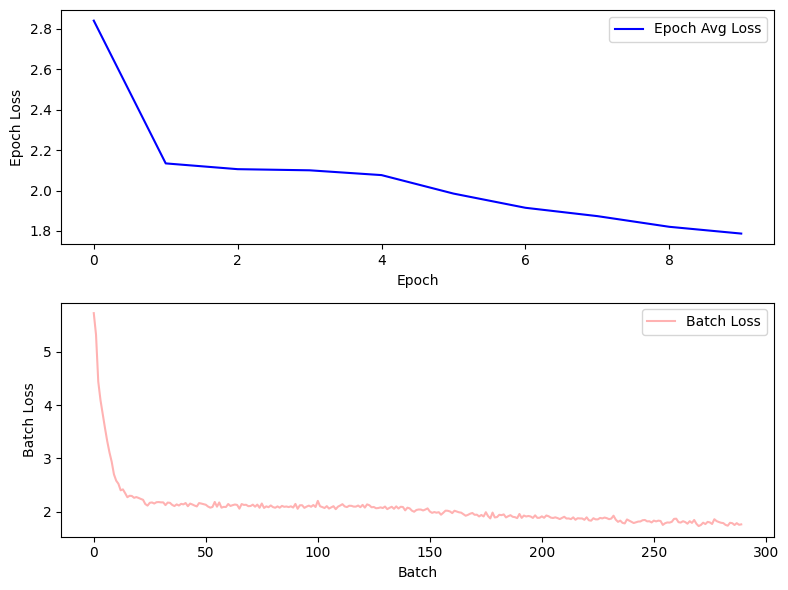

Clustering 14820 points in 4D to 64 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.01 s, search 0.01 s): objective=517.975 imbalance=1.219 nsplit=0       
Clustering 14820 points in 4D to 64 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.00 s, search 0.00 s): objective=549.369 imbalance=1.263 nsplit=0       
Clustering 14820 points in 4D to 64 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.01 s, search 0.00 s): objective=341.648 imbalance=1.228 nsplit=0       
Clustering 14820 points in 4D to 64 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.01 s, search 0.00 s): objective=445.573 imbalance=1.256 nsplit=0       
Clustering 14820 points in 4D to 64 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.01 s, search 0.00 s): objective=385.65 imbalance=1.220 nsplit=0        
Clustering 14820 points in 4D to 64 clusters, redo

Pre-Training:   0%|          | 0/20 [00:00<?, ?it/s]

perplexity_per_codebook [57.76594161987305, 56.62458419799805, 53.66706848144531, 55.52811813354492, 56.3101692199707, 58.045921325683594, 53.29175567626953, 56.59667205810547, 55.17839431762695, 54.40902328491211, 56.06430435180664, 54.06634521484375, 55.07535171508789, 55.18741989135742, 56.297176361083984, 56.255802154541016, 57.734737396240234, 58.17876434326172, 59.05449295043945, 59.1593132019043, 58.9271240234375, 59.01643371582031, 58.186370849609375, 55.93052673339844, 58.101806640625, 57.75814437866211, 57.36528778076172, 58.111114501953125, 58.450435638427734, 59.586612701416016, 58.03883743286133, 56.79713439941406] dead_rate_per_codebook[0.0, 0.0, 0.015625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015625, 0.015625, 0.0, 0.015625, 0.0, 0.015625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.10870562493801117 1.636012315750122 0.0039006629958748817 0.0011115842498838902
perplexity_per_codebook [57.03226852416992, 57.965877532958984, 55.0441589

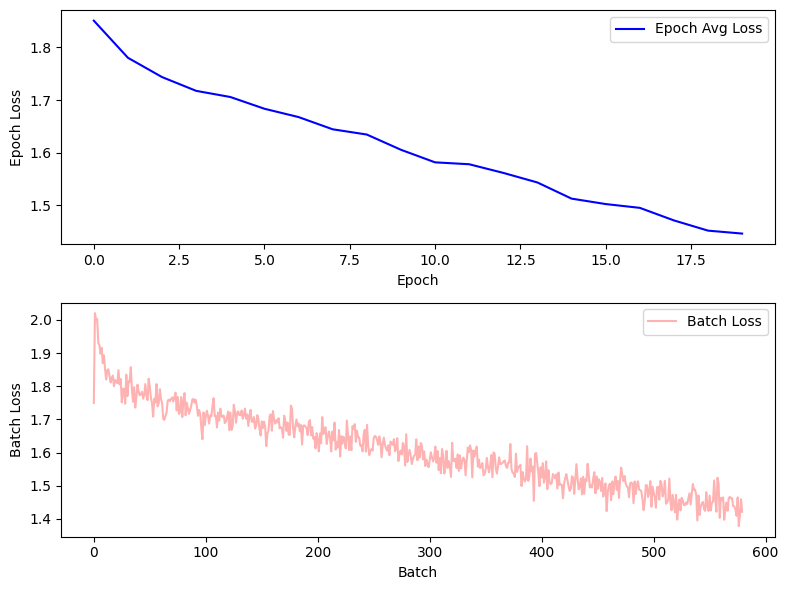

In [8]:
vqtcr = vq.vqTCR(params, adata, labels='cluster_tcell')
vqtcr.pretrain(col_name='patient', 
               set_name=['su010','su011','su013','su014'],
               sample_mode='clonotype', 
               shuffle=False,
               labels=None,
               visual=True)

In [9]:
adata = vqtcr.get_latent(adata, col_name='patient', set_name=['su010','su011','su013','su014'], gene_analys=True)

perplexity_per_codebook [30.59191131591797, 28.906173706054688, 27.815370559692383, 34.86387634277344, 30.151702880859375, 30.10739517211914, 36.390045166015625, 30.430578231811523, 34.027061462402344, 34.91499328613281, 31.41214370727539, 36.26083755493164, 33.92306137084961, 37.62669372558594, 33.231502532958984, 37.04587173461914, 34.79233169555664, 28.44993782043457, 32.583248138427734, 33.135337829589844, 25.386606216430664, 42.227294921875, 36.772865295410156, 42.98029327392578, 19.90868377685547, 20.62427520751953, 26.310625076293945, 32.3286018371582, 31.00996208190918, 31.913585662841797, 22.3917293548584, 35.7856330871582] dead_rate_per_codebook[0.0625, 0.09375, 0.125, 0.0625, 0.171875, 0.078125, 0.046875, 0.15625, 0.09375, 0.046875, 0.15625, 0.046875, 0.0625, 0.015625, 0.09375, 0.03125, 0.140625, 0.1875, 0.203125, 0.125, 0.203125, 0.03125, 0.109375, 0.03125, 0.328125, 0.34375, 0.296875, 0.171875, 0.15625, 0.15625, 0.328125, 0.171875]
perplexity_per_codebook [29.2316417694091

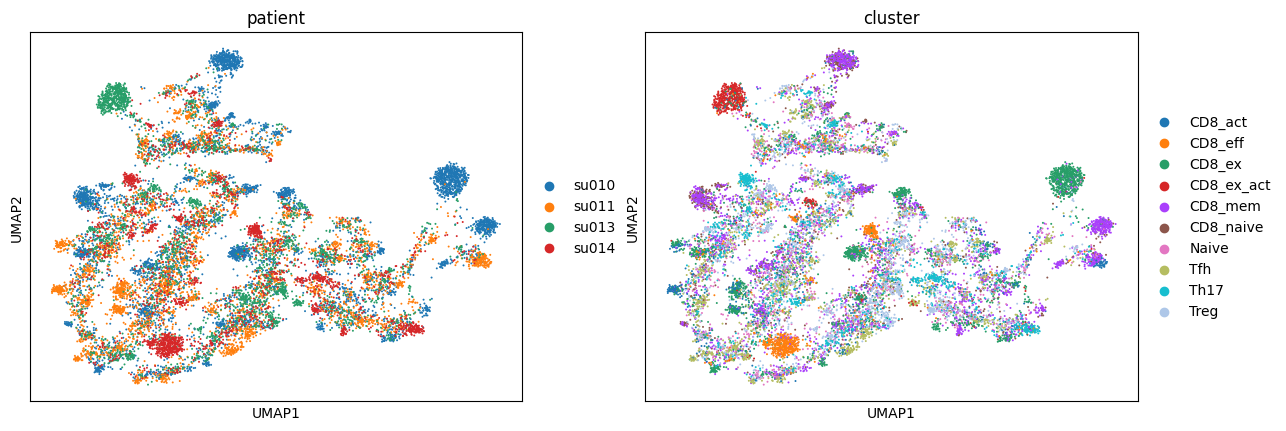

In [10]:
# tcr latent space
sc.pp.neighbors(adata, use_rep='htcell')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['patient', 'cluster'])

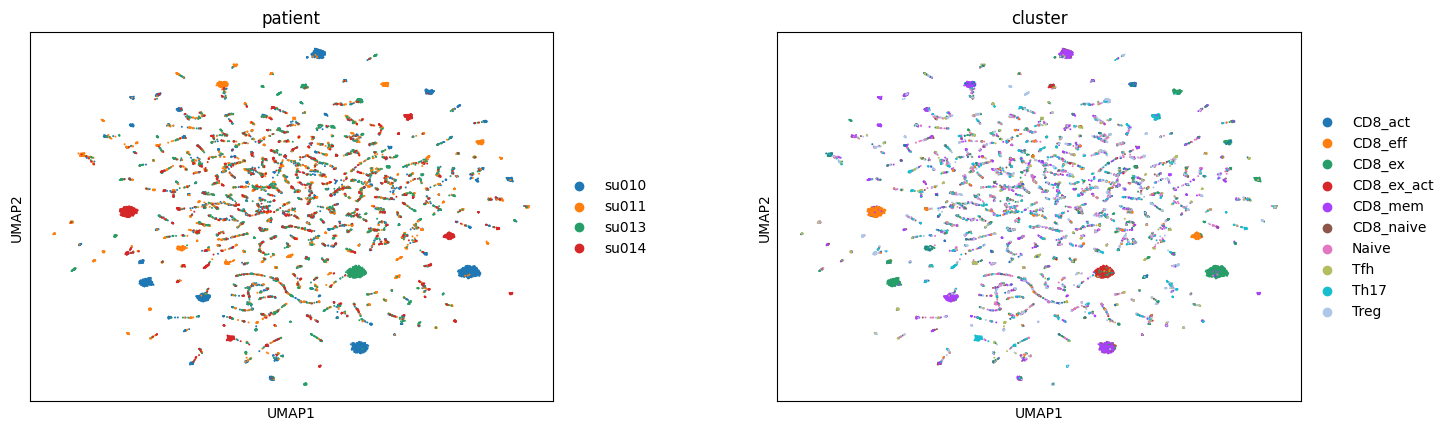

In [11]:
# tcr latent space
sc.pp.neighbors(adata, use_rep='htcr')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['patient', 'cluster'], wspace=0.3)

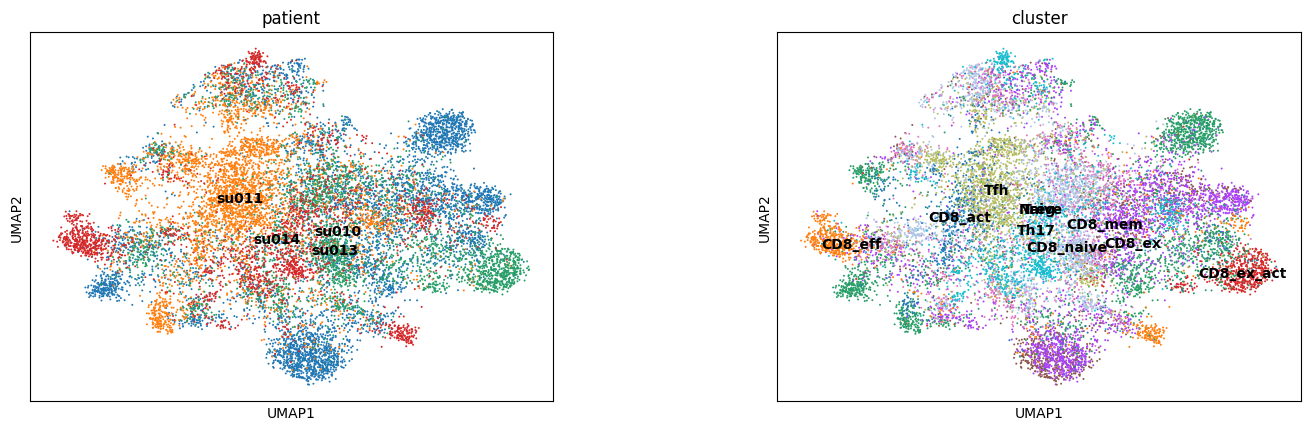

In [12]:
# gex residual latent space
sc.pp.neighbors(adata, use_rep='hgex')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['patient', 'cluster'], wspace=0.3, legend_loc='on data')

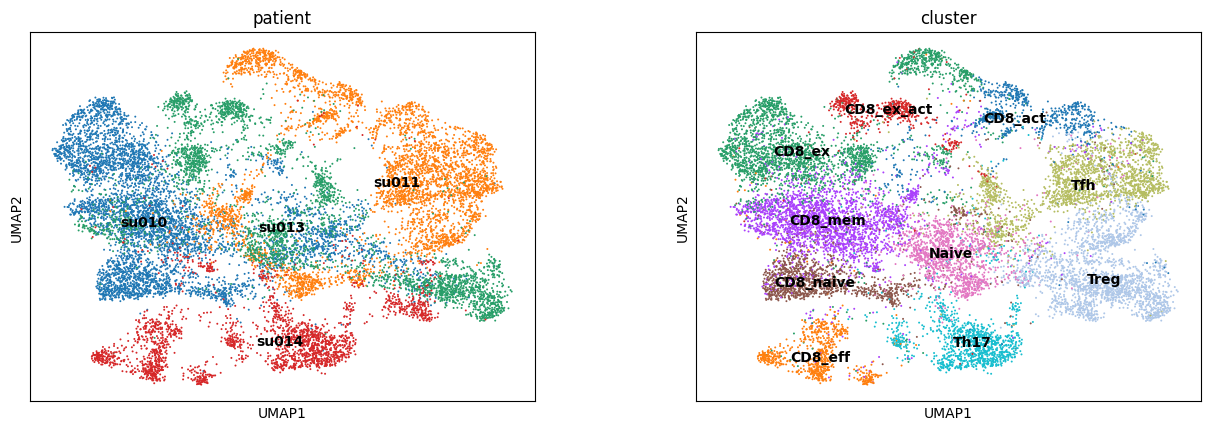

In [13]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['patient', 'cluster'], wspace=0.2, legend_loc='on data')

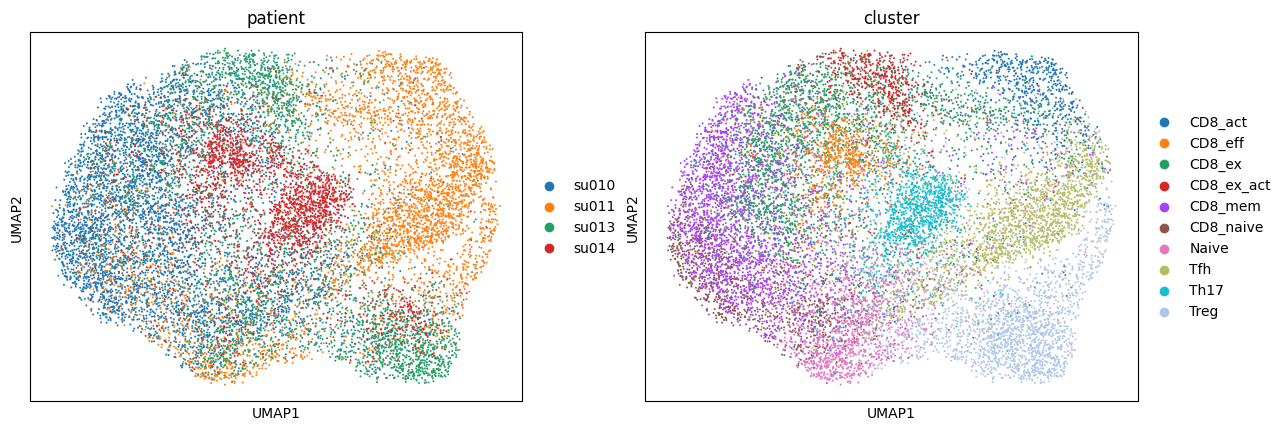

In [14]:
adata_base = adata.copy()
adata_base.X = adata.obsm['base_tcells']
sc.tl.pca(adata_base)
sc.pp.neighbors(adata_base)
sc.tl.umap(adata_base)
sc.pl.umap(adata_base, color=['patient', 'cluster'])

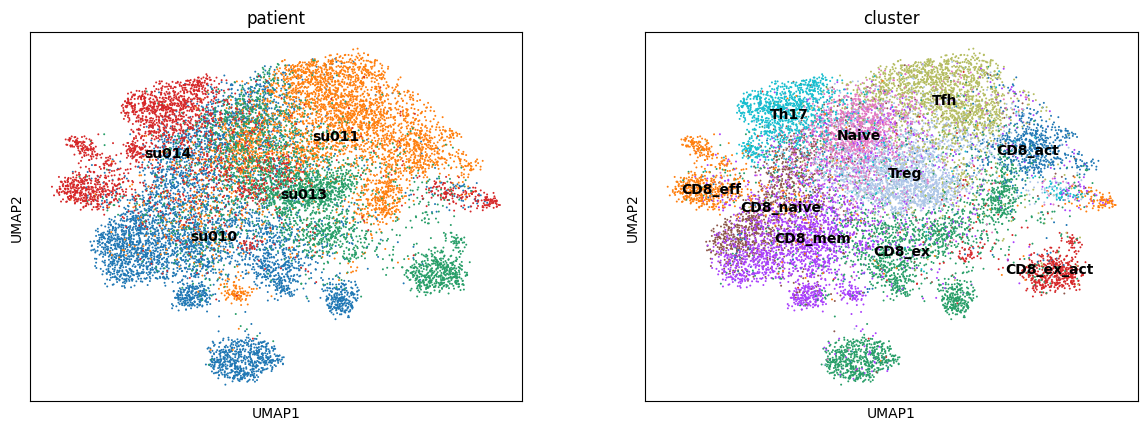

In [15]:
adata_bias = adata.copy()
adata_bias.X = adata.obsm['bias_gexs']
sc.tl.pca(adata_bias)
sc.pp.neighbors(adata_bias)
sc.tl.umap(adata_bias)
sc.pl.umap(adata_bias, color=['patient', 'cluster'], legend_loc='on data')

三元图绘制——ex\act\ex_act, 治疗前后各个病人的变化 (10/11 response)

In [16]:
adata.obs.cluster.value_counts()

CD8_ex        2562
CD8_mem       2509
Treg          2088
Tfh           1900
Naive         1346
CD8_naive     1227
Th17          1191
CD8_eff        747
CD8_act        707
CD8_ex_act     543
Name: cluster, dtype: int64

In [17]:
adata.obs.to_csv("obs.csv")

In [18]:
import pandas as pd
import numpy as np

obs = pd.read_csv("obs.csv")

# 查看一下基本信息
print(obs["cluster"].value_counts())
print(obs["treatment"].value_counts())
print(obs["patient"].value_counts())


CD8_ex        2562
CD8_mem       2509
Treg          2088
Tfh           1900
Naive         1346
CD8_naive     1227
Th17          1191
CD8_eff        747
CD8_act        707
CD8_ex_act     543
Name: cluster, dtype: int64
pre     8204
post    6616
Name: treatment, dtype: int64
su010    5355
su011    4000
su013    3126
su014    2339
Name: patient, dtype: int64


In [19]:
# 只保留 CD8 相关 cluster
cd8_mask = obs["cluster"].str.startswith("CD8_")
obs_cd8 = obs[cd8_mask].copy()

obs_cd8["cd8_state3"] = np.nan
obs_cd8.loc[obs_cd8["cluster"].isin(["CD8_mem", "CD8_naive"]), "cd8_state3"] = "CD8_mem"
obs_cd8.loc[obs_cd8["cluster"].isin(["CD8_act", "CD8_eff"]),  "cd8_state3"] = "CD8_act_eff"
obs_cd8.loc[obs_cd8["cluster"].isin(["CD8_ex", "CD8_ex_act"]), "cd8_state3"] = "CD8_ex"

obs_cd8 = obs_cd8.dropna(subset=["cd8_state3"])


In [20]:
cd4_mask = obs["cluster"].isin(["Treg", "Tfh", "Th17"])
obs_cd4 = obs[cd4_mask].copy()
obs_cd4["cd4_state3"] = obs_cd4["cluster"]  # 直接用原名字


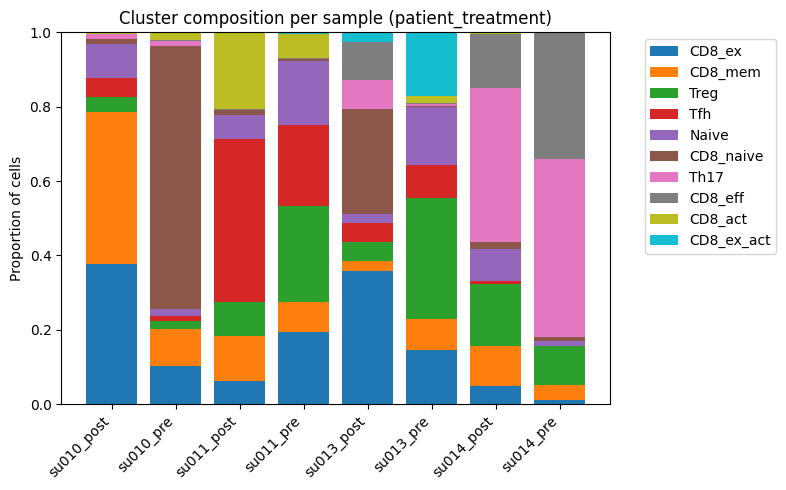

In [21]:
import matplotlib.pyplot as plt

# 统计 patient × treatment × cluster 的细胞数
comp_all = (
    obs.groupby(["patient", "treatment", "cluster"])
       .size()
       .reset_index(name="n_cells")
)

# 方便画图：每一列是一个样本( patient+treatment )
comp_all["sample"] = comp_all["patient"] + "_" + comp_all["treatment"]

pivot_all = comp_all.pivot_table(index="cluster",
                                 columns="sample",
                                 values="n_cells",
                                 fill_value=0)

# 按总量排序 cluster（可选）
cluster_order = pivot_all.sum(axis=1).sort_values(ascending=False).index
pivot_all = pivot_all.loc[cluster_order]

# 计算每个 sample 的总细胞数，用于比例（可选）
col_sums = pivot_all.sum(axis=0)
pivot_prop = pivot_all / col_sums

# 画堆叠条形图（比例）
fig, ax = plt.subplots(figsize=(8, 5))

bottom = np.zeros(len(pivot_prop.columns))
x = np.arange(len(pivot_prop.columns))

for cl in pivot_prop.index:
    values = pivot_prop.loc[cl].values
    ax.bar(x, values, bottom=bottom, label=cl)
    bottom += values

ax.set_xticks(x)
ax.set_xticklabels(pivot_prop.columns, rotation=45, ha="right")
ax.set_ylabel("Proportion of cells")
ax.set_title("Cluster composition per sample (patient_treatment)")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


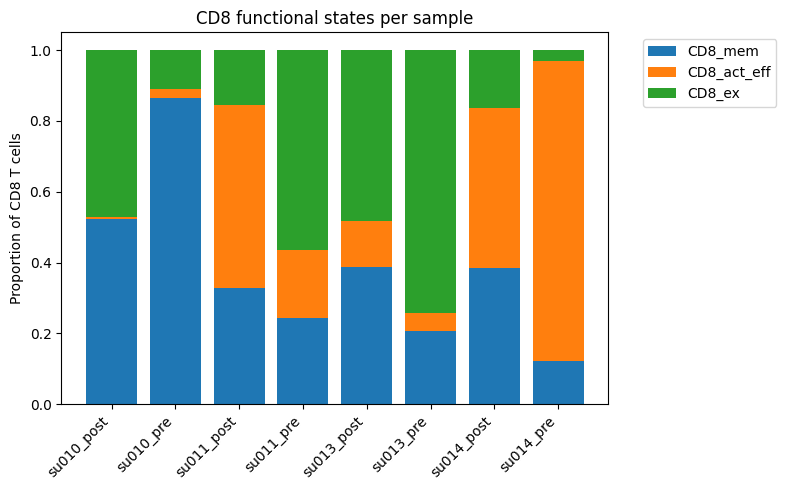

In [22]:
# 统计 patient × treatment × cd8_state3
comp_cd8 = (
    obs_cd8.groupby(["patient", "treatment", "cd8_state3"])
           .size()
           .reset_index(name="n_cells")
)

comp_cd8["sample"] = comp_cd8["patient"] + "_" + comp_cd8["treatment"]

pivot_cd8 = comp_cd8.pivot_table(index="cd8_state3",
                                 columns="sample",
                                 values="n_cells",
                                 fill_value=0)

# 计算比例
col_sums = pivot_cd8.sum(axis=0)
pivot_cd8_prop = pivot_cd8 / col_sums

# 固定顺序：记忆 -> 激活效应 -> 耗竭
cd8_order = ["CD8_mem", "CD8_act_eff", "CD8_ex"]
pivot_cd8_prop = pivot_cd8_prop.loc[cd8_order]

fig, ax = plt.subplots(figsize=(8, 5))

bottom = np.zeros(len(pivot_cd8_prop.columns))
x = np.arange(len(pivot_cd8_prop.columns))

for state in pivot_cd8_prop.index:
    values = pivot_cd8_prop.loc[state].values
    ax.bar(x, values, bottom=bottom, label=state)
    bottom += values

ax.set_xticks(x)
ax.set_xticklabels(pivot_cd8_prop.columns, rotation=45, ha="right")
ax.set_ylabel("Proportion of CD8 T cells")
ax.set_title("CD8 functional states per sample")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [23]:
import plotly.graph_objects as go

# 先计算 patient × treatment 三个状态的比例
target_states = ["CD8_mem", "CD8_act_eff", "CD8_ex"]

counts = (
    obs_cd8.groupby(["patient", "treatment", "cd8_state3"])
           .size()
           .reset_index(name="n_cells")
)

counts_wide = counts.pivot_table(index=["patient", "treatment"],
                                 columns="cd8_state3",
                                 values="n_cells",
                                 fill_value=0).reset_index()

# 确保三列都有
for st in target_states:
    if st not in counts_wide.columns:
        counts_wide[st] = 0

counts_wide["total"] = counts_wide[target_states].sum(axis=1)
for st in target_states:
    counts_wide[st] = counts_wide[st] / counts_wide["total"].replace(0, np.nan)

counts_wide = counts_wide.dropna(subset=["total"])

fig = go.Figure()

for patient_id, df_pat in counts_wide.groupby("patient"):
    df_pre  = df_pat[df_pat["treatment"] == "pre"]
    df_post = df_pat[df_pat["treatment"] == "post"]
    if df_pre.empty or df_post.empty:
        continue

    pre_row = df_pre.iloc[0]
    post_row = df_post.iloc[0]

    fig.add_trace(
        go.Scatterternary(
            a=[pre_row["CD8_mem"], post_row["CD8_mem"]],
            b=[pre_row["CD8_act_eff"],   post_row["CD8_act_eff"]],
            c=[pre_row["CD8_ex"],  post_row["CD8_ex"]],
            mode="lines+markers",
            name=str(patient_id),
            text=[f"{patient_id} pre", f"{patient_id} post"],
            hovertemplate=(
                "sample: %{text}<br>" +
                "CD8_mem: %{a:.2f}<br>" +
                "CD8_act_eff: %{b:.2f}<br>" +
                "CD8_ex: %{c:.2f}<extra></extra>"
            ),
        )
    )

fig.update_layout(
    ternary=dict(
        sum=1,
        aaxis=dict(title="CD8_mem"),
        baxis=dict(title="CD8_act_eff"),
        caxis=dict(title="CD8_ex"),
    ),
    title="CD8 functional state composition per patient (pre → post)",
    legend_title_text="patient",
)

fig.show()


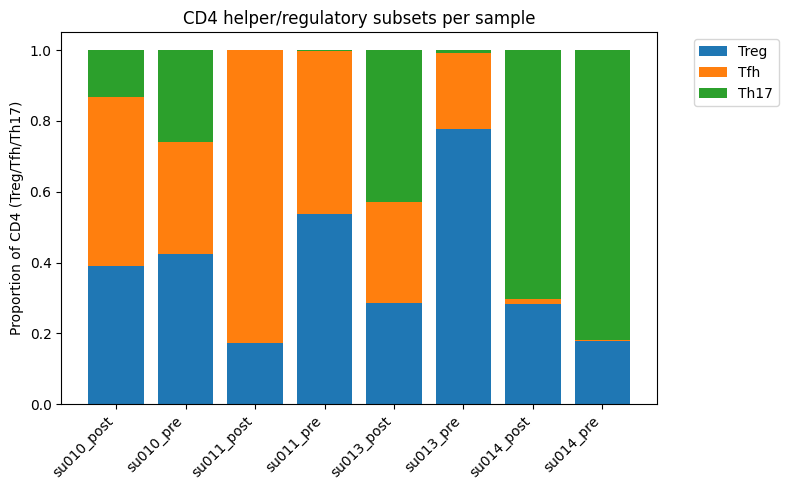

In [24]:
comp_cd4 = (
    obs_cd4.groupby(["patient", "treatment", "cd4_state3"])
           .size()
           .reset_index(name="n_cells")
)

comp_cd4["sample"] = comp_cd4["patient"] + "_" + comp_cd4["treatment"]

pivot_cd4 = comp_cd4.pivot_table(index="cd4_state3",
                                 columns="sample",
                                 values="n_cells",
                                 fill_value=0)

col_sums = pivot_cd4.sum(axis=0)
pivot_cd4_prop = pivot_cd4 / col_sums

# 固定顺序（可调整）
cd4_order = ["Treg", "Tfh", "Th17"]
pivot_cd4_prop = pivot_cd4_prop.loc[cd4_order]

fig, ax = plt.subplots(figsize=(8, 5))

bottom = np.zeros(len(pivot_cd4_prop.columns))
x = np.arange(len(pivot_cd4_prop.columns))

for state in pivot_cd4_prop.index:
    values = pivot_cd4_prop.loc[state].values
    ax.bar(x, values, bottom=bottom, label=state)
    bottom += values

ax.set_xticks(x)
ax.set_xticklabels(pivot_cd4_prop.columns, rotation=45, ha="right")
ax.set_ylabel("Proportion of CD4 (Treg/Tfh/Th17)")
ax.set_title("CD4 helper/regulatory subsets per sample")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [25]:
import plotly.graph_objects as go
import plotly.express as px

# 为每个病人分配不同颜色（Dark24 调色板）
patient_list = sorted(counts_wide["patient"].unique())
palette = px.colors.qualitative.Dark24
color_map = {p: palette[i % len(palette)] for i, p in enumerate(patient_list)}

fig = go.Figure()

for patient_id, df_pat in counts_wide.groupby("patient"):
    df_pre  = df_pat[df_pat["treatment"] == "pre"]
    df_post = df_pat[df_pat["treatment"] == "post"]
    if df_pre.empty or df_post.empty:
        continue

    pre = df_pre.iloc[0]
    post = df_post.iloc[0]

    color = color_map[patient_id]

    # ---- 1. pre→post line ----
    fig.add_trace(
        go.Scatterternary(
            a=[pre["CD8_mem"], post["CD8_mem"]],
            b=[pre["CD8_act_eff"],   post["CD8_act_eff"]],
            c=[pre["CD8_ex"],  post["CD8_ex"]],
            mode="lines",
            line=dict(width=2, color=color),
            showlegend=False
        )
    )

    # ---- 2. pre = circle ----
    fig.add_trace(
        go.Scatterternary(
            a=[pre["CD8_mem"]],
            b=[pre["CD8_act_eff"]],
            c=[pre["CD8_ex"]],
            mode="markers",
            marker=dict(symbol="circle", color=color, size=10),
            name=f"{patient_id} pre"
        )
    )

    # ---- 3. post = square ----
    fig.add_trace(
        go.Scatterternary(
            a=[post["CD8_mem"]],
            b=[post["CD8_act_eff"]],
            c=[post["CD8_ex"]],
            mode="markers",
            marker=dict(symbol="square", color=color, size=12),
            name=f"{patient_id} post"
        )
    )

fig.update_layout(
    ternary=dict(
        sum=1,
        aaxis=dict(title="CD8_mem_total"),
        baxis=dict(title="CD8_act_eff"),
        caxis=dict(title="CD8_ex_total"),
    ),
    title="CD8 functional state composition per patient (pre → post)",
    legend_title_text="Patient"
)

fig.show()

FiLM parameters interpretation

残差衡量每个原型的样本异质性，连续结构，gamma和beta解释由哪些基因主导了这些原型的异质性
- 不同细胞类型内的film参数反映由不同基因主导的方向变化

In [26]:
import numpy as np
import pandas as pd

# 你已有的 obs 设置
obs = adata.obs.copy()

cd8_mask = obs["cluster"].str.startswith("CD8_")
obs_cd8 = obs[cd8_mask].copy()

obs_cd8["cd8_state3"] = np.nan
obs_cd8.loc[obs_cd8["cluster"].isin(["CD8_mem", "CD8_naive"]), "cd8_state3"] = "CD8_mem"
obs_cd8.loc[obs_cd8["cluster"].isin(["CD8_act", "CD8_eff"]),  "cd8_state3"] = "CD8_act_eff"
obs_cd8.loc[obs_cd8["cluster"].isin(["CD8_ex", "CD8_ex_act"]), "cd8_state3"] = "CD8_ex"

obs_cd8 = obs_cd8.dropna(subset=["cd8_state3"])

# 加入到 adata.obs（非 CD8 的设为 NA）
adata.obs["cd8_state3"] = np.nan
adata.obs.loc[obs_cd8.index, "cd8_state3"] = obs_cd8["cd8_state3"]
adata

AnnData object with n_obs × n_vars = 14820 × 5000
    obs: 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'cdr3s_nt', 'cdr3s_aa', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clonotype', 'clonotype_size', 'VJ_1_junction_aa', 'VDJ_1_junction_aa', 'alpha_len', 'beta_len', 'cd8_state3'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'chain_indices', 'clonotype', 'cluster_colors', 'hvg', 'ir_dist_nt_identity', 'log1p', 'patient_colors', 'treatment_colors', 'neighbors', 'umap', 'pca'
    obsm: 'airr', 'alpha_mask', 'alpha_seq', 'beta_mask', 'beta_seq', 'chain_indices', 'htcell', 'htcr', 'hgex', 'base_tcells', 'bias_gexs', 'gammas', 'betas', 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [27]:
adata_cd8 = adata[adata.obs["cd8_state3"].isin(["CD8_act_eff", "CD8_ex"])].copy()

In [28]:
import scanpy as sc

sc.tl.rank_genes_groups(
    adata_cd8,
    groupby="cd8_state3",
    groups=["CD8_ex"],
    reference="CD8_act_eff",
    method="wilcoxon"
)

de = sc.get.rank_genes_groups_df(adata_cd8, group="CD8_ex")
de = de.set_index("names")
de

scores  logfoldchanges          pvals      pvals_adj
names                                                          
CD7     37.313805        2.020852  9.801518e-305  4.900759e-301
CD8A    33.683510        2.484700  1.008023e-248  2.520058e-245
CREM    29.608919        2.338547  1.147150e-192  1.433937e-189
FTH1    29.509039        1.384101  2.204349e-191  2.204349e-188
GALNT2  29.326094        2.962697  4.822395e-189  4.018662e-186
...           ...             ...            ...            ...
DNAJA1 -24.298655       -1.387335  2.025594e-130  6.751980e-128
CD48   -26.349524       -1.975451  5.197239e-153  2.165516e-150
DNAJB1 -26.640366       -2.822180  2.314312e-156  1.051960e-153
HSPA1B -28.500793       -3.901223  1.145190e-178  7.157440e-176
HSPA1A -33.223885       -3.842103  4.866636e-242  8.111060e-239

[5000 rows x 4 columns]

In [29]:
sig_genes_ex = de.query("logfoldchanges > 0 and pvals_adj < 0.05").index.tolist()
# 或者取 top 100/200 个 logFC 最大的
sig_genes_ex = (
    de.query("logfoldchanges > 0")
      .sort_values("pvals_adj")
      .head(200).index.tolist()
)
sig_genes_ex

['CD7',
 'CD8A',
 'CREM',
 'FTH1',
 'GALNT2',
 'SLA2',
 'AC092580.4',
 'LDHA',
 'ENTPD1',
 'SAMSN1',
 'CTSW',
 'TIGIT',
 'GABARAPL1',
 'CXCR4',
 'SLC7A5',
 'CD8B',
 'KLRC1',
 'CXCR6',
 'ATP1B3',
 'GNLY',
 'TSC22D3',
 'ITGAE',
 'ZFP36L2',
 'SYTL3',
 'SRGN',
 'RPS26',
 'BIRC3',
 'PTPN22',
 'HLA-A',
 'CXCL13',
 'RALA',
 'DUSP4',
 'TGFB1',
 'LGALS3',
 'PABPC1',
 'LAYN',
 'AHI1',
 'NELL2',
 'FAM177A1',
 'CAMK4',
 'LYST',
 'MT-CYB',
 'SYNGR2',
 'PRF1',
 'RBPJ',
 'NR3C1',
 'CARS',
 'IL7R',
 'PDE4DIP',
 'PBXIP1',
 'IGKC',
 'BTG1',
 'VCAM1',
 'FLNA',
 'STAT5A',
 'SQSTM1',
 'BIRC2',
 'CMIP',
 'PDE4A',
 'LDLRAD4',
 'HAVCR2',
 'CLIC3',
 'JAML',
 'ISG20',
 'MT-ND3',
 'SOX4',
 'MT-CO2',
 'KLRD1',
 'SEC14L1',
 'GLIPR1',
 'NFKB2',
 'DCXR',
 'ITM2A',
 'CAPG',
 'EZR',
 'B2M',
 'MT-CO1',
 'VPS37B',
 'GTF3C1',
 'ACP5',
 'IL2RB',
 'TANK',
 'MT-CO3',
 'PFKFB3',
 'EIF3J',
 'ARID5A',
 'RNF19A',
 'HLA-DRB5',
 'GZMM',
 'NINJ1',
 'PDE4D',
 'CD55',
 'CBLB',
 'PKIA',
 'GZMB',
 'GAPDH',
 'IL9R',
 'IGHG1',
 'GGA2',


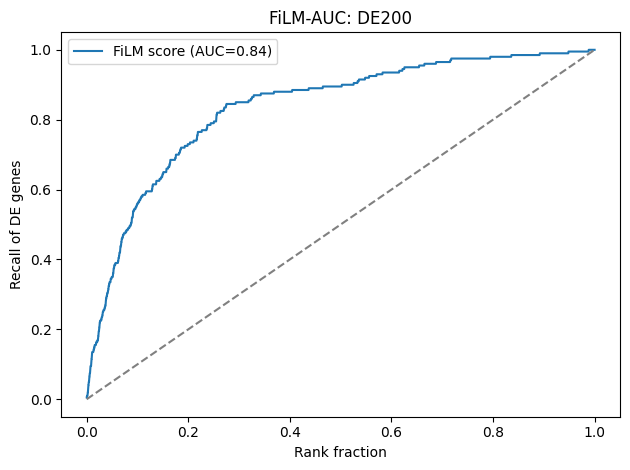

In [30]:
insect_genes = set(sig_genes_ex) & set(adata.var_names)
gammas = adata_cd8.obsm["gammas"]  # 已经是 (1+γ_raw)
betas  = adata_cd8.obsm["betas"]
genes = adata_cd8.var_names
gamma_dev = gammas - 1.0    # 偏离量
beta_dev  = betas   
cells_ex  = adata_cd8.obs["cd8_state3"] == "CD8_ex"
cells_act = adata_cd8.obs["cd8_state3"] == "CD8_act_eff"

g_ex  = gamma_dev[cells_ex].mean(axis=0)
g_act = gamma_dev[cells_act].mean(axis=0)
d_gamma = g_ex - g_act

b_ex  = betas[cells_ex].mean(axis=0)
b_act = betas[cells_act].mean(axis=0)
d_beta = b_ex - b_act

film_score = np.abs(d_gamma) + np.abs(d_beta)
film_score_l2 = np.sqrt(d_gamma**2 + d_beta**2)

fi = pd.DataFrame({
    "gene": genes,
    "d_gamma": d_gamma,
    "d_beta": d_beta,
    "film_score": film_score,
    'film_score_l2':film_score_l2,
}).set_index("gene")

def film_enrichment_curve(score_series, insect_genes):
    score_series = score_series.dropna()
    genes_sorted = score_series.sort_values(ascending=False).index.tolist()
    N = len(genes_sorted)

    hits = np.array([g in insect_genes for g in genes_sorted], dtype=bool)
    recall = np.cumsum(hits) / hits.sum()
    x = np.arange(1, N+1) / N
    auc = np.trapz(recall, x)
    return x, recall, auc
import matplotlib.pyplot as plt

x, y, auc = film_enrichment_curve(fi["film_score"], insect_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of DE genes")
plt.title(f"FiLM-AUC: DE200")
plt.legend()
plt.tight_layout()
plt.show()


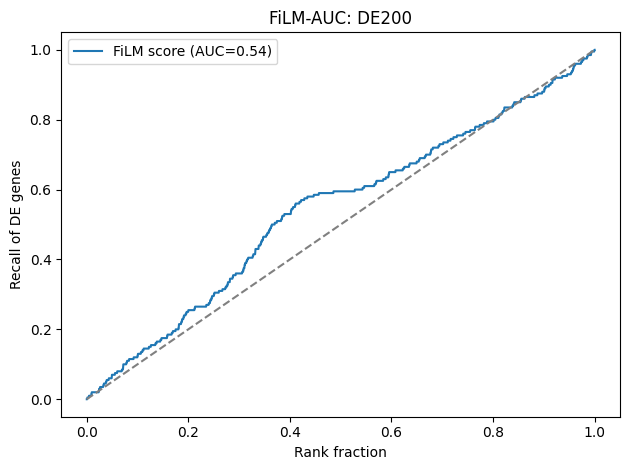

In [31]:
x, y, auc = film_enrichment_curve(fi["d_gamma"], insect_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of DE genes")
plt.title(f"FiLM-AUC: DE200")
plt.legend()
plt.tight_layout()
plt.show()

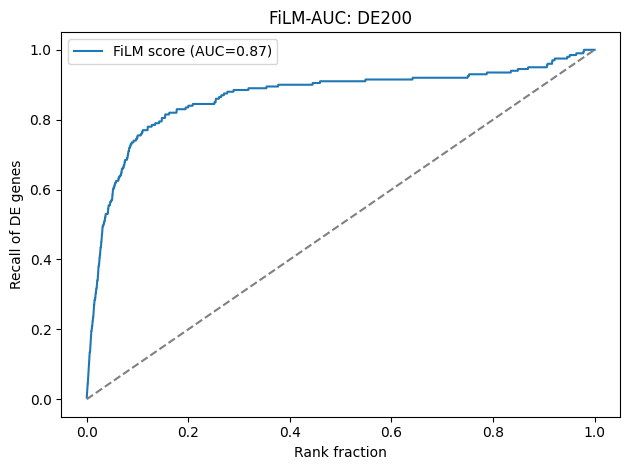

In [32]:
x, y, auc = film_enrichment_curve(fi["d_beta"], insect_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of DE genes")
plt.title(f"FiLM-AUC: DE200")
plt.legend()
plt.tight_layout()
plt.show()

pathway genes hit of top genes in film

In [33]:
def load_gmt(path):
    gene_sets = {}
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            name = parts[0]
            genes = set(parts[2:])
            gene_sets[name] = genes
    return gene_sets

# 使用你的本地文件路径：
gene_sets = load_gmt("h.all.v2025.1.Hs.symbols.gmt")
gene_sets

{'HALLMARK_ADIPOGENESIS': {'ABCA1',
  'ABCB8',
  'ACAA2',
  'ACADL',
  'ACADM',
  'ACADS',
  'ACLY',
  'ACO2',
  'ACOX1',
  'ADCY6',
  'ADIG',
  'ADIPOQ',
  'ADIPOR2',
  'AGPAT3',
  'AIFM1',
  'AK2',
  'ALDH2',
  'ALDOA',
  'ANGPT1',
  'ANGPTL4',
  'APLP2',
  'APOE',
  'ARAF',
  'ARL4A',
  'ATL2',
  'ATP1B3',
  'ATP5PO',
  'BAZ2A',
  'BCKDHA',
  'BCL2L13',
  'BCL6',
  'C3',
  'CAT',
  'CAVIN1',
  'CAVIN2',
  'CCNG2',
  'CD151',
  'CD302',
  'CD36',
  'CDKN2C',
  'CHCHD10',
  'CHUK',
  'CIDEA',
  'CMBL',
  'CMPK1',
  'COL15A1',
  'COL4A1',
  'COQ3',
  'COQ5',
  'COQ9',
  'COX6A1',
  'COX7B',
  'COX8A',
  'CPT2',
  'CRAT',
  'CS',
  'CYC1',
  'CYP4B1',
  'DBT',
  'DDT',
  'DECR1',
  'DGAT1',
  'DHCR7',
  'DHRS7',
  'DHRS7B',
  'DLAT',
  'DLD',
  'DNAJB9',
  'DNAJC15',
  'DRAM2',
  'ECH1',
  'ECHS1',
  'ELMOD3',
  'ELOVL6',
  'ENPP2',
  'EPHX2',
  'ESRRA',
  'ESYT1',
  'ETFB',
  'FABP4',
  'FAH',
  'FZD4',
  'G3BP2',
  'GADD45A',
  'GBE1',
  'GHITM',
  'GPAM',
  'GPAT4',
  'GPD2',
  'GPHN

In [34]:
pathway = "HALLMARK_APOPTOSIS"
pathway_genes = gene_sets[pathway] & set(adata.var_names)
len(pathway_genes)

83

In [35]:
gammas = adata_cd8.obsm["gammas"]  # 已经是 (1+γ_raw)
betas  = adata_cd8.obsm["betas"]
genes = adata_cd8.var_names
gamma_dev = gammas - 1.0    # 偏离量
beta_dev  = betas           # 偏离量

In [36]:
cells_ex  = adata_cd8.obs["cd8_state3"] == "CD8_ex"
cells_act = adata_cd8.obs["cd8_state3"] == "CD8_act_eff"

g_ex  = gamma_dev[cells_ex].mean(axis=0)
g_act = gamma_dev[cells_act].mean(axis=0)
d_gamma = g_ex - g_act

b_ex  = betas[cells_ex].mean(axis=0)
b_act = betas[cells_act].mean(axis=0)
d_beta = b_ex - b_act

film_score = np.abs(d_gamma) + np.abs(d_beta)
film_score_l2 = np.sqrt(d_gamma**2 + d_beta**2)

fi = pd.DataFrame({
    "gene": genes,
    "d_gamma": d_gamma,
    "d_beta": d_beta,
    "film_score": film_score,
    'film_score_l2':film_score_l2,
}).set_index("gene")
fi

d_gamma    d_beta  film_score  film_score_l2
gene                                                        
RP11-34P13.7   0.000076 -0.003809    0.003885       0.003810
FO538757.2    -0.001550  0.000535    0.002085       0.001640
RP11-206L10.9 -0.004435 -0.000171    0.004606       0.004438
LINC00115     -0.000069  0.000537    0.000606       0.000541
KLHL17        -0.000954  0.001387    0.002341       0.001684
...                 ...       ...         ...            ...
RP5-855D21.2   0.000008  0.006195    0.006203       0.006195
SCARA5         0.001241 -0.001421    0.002662       0.001887
SCN2B          0.000909 -0.000542    0.001451       0.001058
CTA-212A2.3   -0.000131  0.001763    0.001894       0.001768
RP1-153P14.5  -0.002149 -0.004302    0.006450       0.004808

[5000 rows x 4 columns]

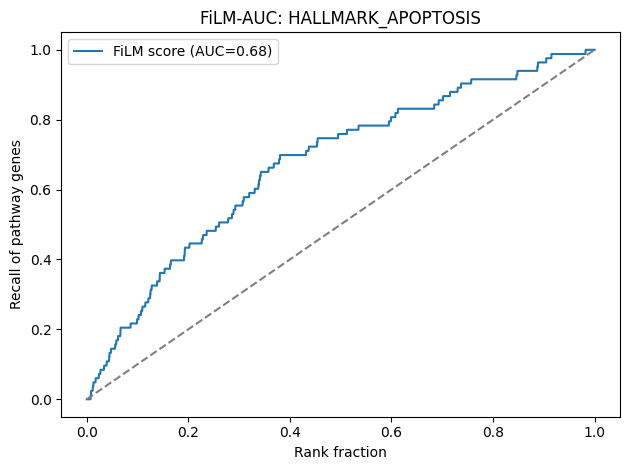

In [37]:
def film_enrichment_curve(score_series, pathway_genes):
    score_series = score_series.dropna()
    genes_sorted = score_series.sort_values(ascending=False).index.tolist()
    N = len(genes_sorted)

    hits = np.array([g in pathway_genes for g in genes_sorted], dtype=bool)
    recall = np.cumsum(hits) / hits.sum()
    x = np.arange(1, N+1) / N
    auc = np.trapz(recall, x)
    return x, recall, auc
import matplotlib.pyplot as plt

x, y, auc = film_enrichment_curve(fi["film_score"], pathway_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of pathway genes")
plt.title(f"FiLM-AUC: {pathway}")
plt.legend()
plt.tight_layout()
plt.show()


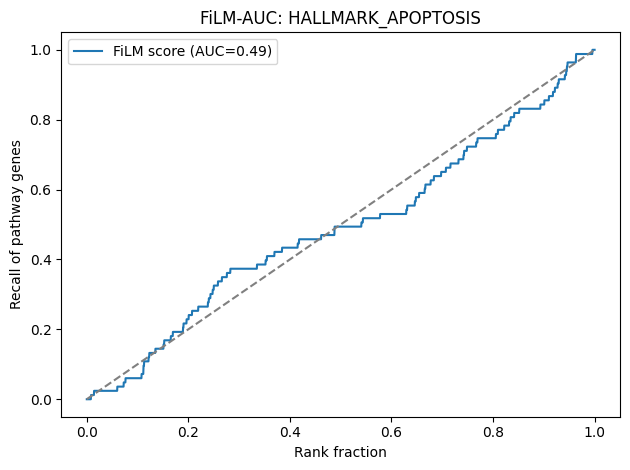

In [38]:
x, y, auc = film_enrichment_curve(fi['d_gamma'], pathway_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of pathway genes")
plt.title(f"FiLM-AUC: {pathway}")
plt.legend()
plt.tight_layout()
plt.show()

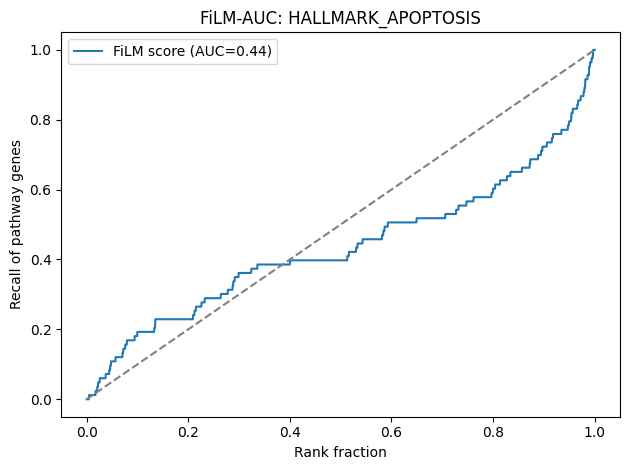

In [39]:
x, y, auc = film_enrichment_curve(fi['d_beta'], pathway_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of pathway genes")
plt.title(f"FiLM-AUC: {pathway}")
plt.legend()
plt.tight_layout()
plt.show()

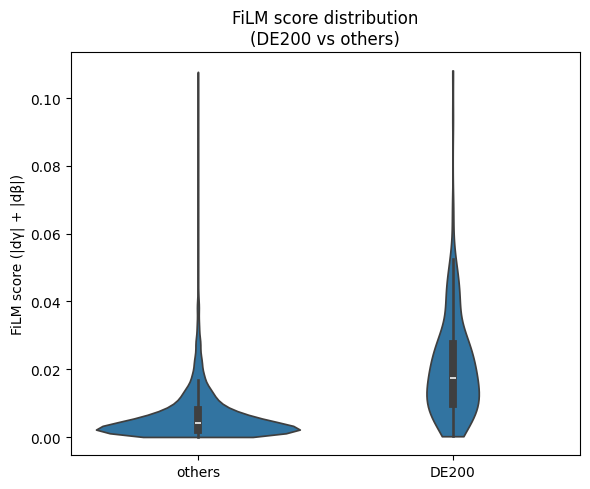

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 假设你已经有：
# fi: DataFrame(index=gene, columns=["d_gamma","d_beta","film_score"])
# sig_genes_ex: list of top200 DE基因

fi_plot = fi.copy()
fi_plot["group"] = ["DE200" if g in sig_genes_ex else "others" for g in fi_plot.index]

plt.figure(figsize=(6,5))
sns.violinplot(data=fi_plot, x="group", y="film_score", cut=0, inner="box")
plt.title("FiLM score distribution\n(DE200 vs others)")
plt.ylabel("FiLM score (|dγ| + |dβ|)")
plt.xlabel("")
plt.tight_layout()
plt.show()


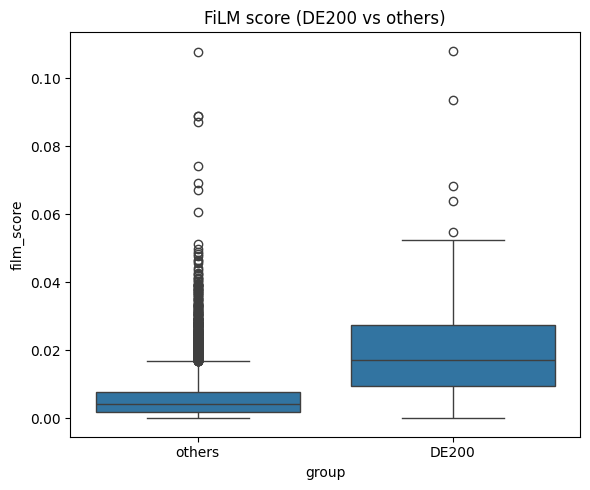

In [41]:
plt.figure(figsize=(6,5))
sns.boxplot(data=fi_plot, x="group", y="film_score")
plt.title("FiLM score (DE200 vs others)")
plt.tight_layout()
plt.show()


In [42]:
fi

d_gamma    d_beta  film_score  film_score_l2
gene                                                        
RP11-34P13.7   0.000076 -0.003809    0.003885       0.003810
FO538757.2    -0.001550  0.000535    0.002085       0.001640
RP11-206L10.9 -0.004435 -0.000171    0.004606       0.004438
LINC00115     -0.000069  0.000537    0.000606       0.000541
KLHL17        -0.000954  0.001387    0.002341       0.001684
...                 ...       ...         ...            ...
RP5-855D21.2   0.000008  0.006195    0.006203       0.006195
SCARA5         0.001241 -0.001421    0.002662       0.001887
SCN2B          0.000909 -0.000542    0.001451       0.001058
CTA-212A2.3   -0.000131  0.001763    0.001894       0.001768
RP1-153P14.5  -0.002149 -0.004302    0.006450       0.004808

[5000 rows x 4 columns]

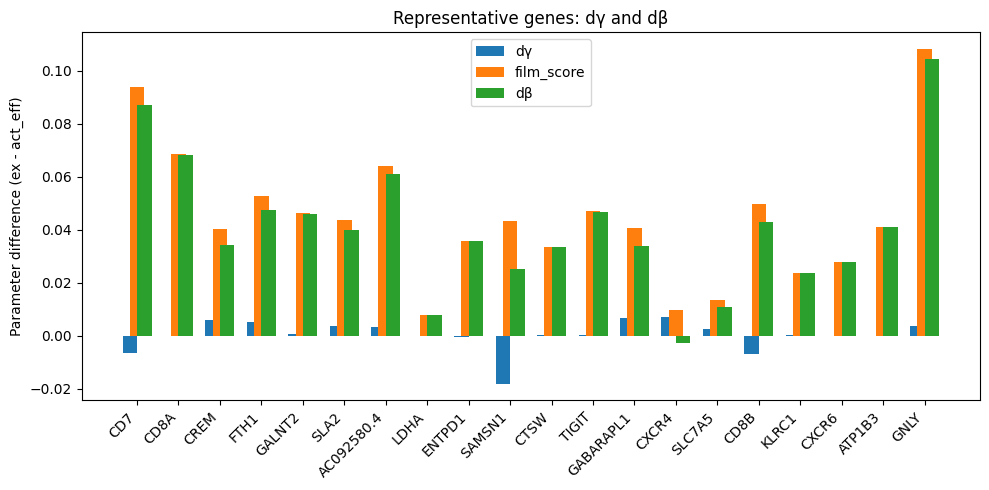

In [43]:

import numpy as np
import matplotlib.pyplot as plt

genes_to_plot = sig_genes_ex[:20]

df_small = fi.loc[genes_to_plot, ["d_gamma", "d_beta", 'film_score']]

plt.figure(figsize=(10,5))
bar_width = 0.35
x = np.arange(len(genes_to_plot))

plt.bar(x - bar_width/2, df_small["d_gamma"], bar_width, label="dγ")
plt.bar(x , df_small["film_score"],  bar_width, label="film_score")
plt.bar(x + bar_width/2, df_small["d_beta"],  bar_width, label="dβ")

plt.xticks(x, genes_to_plot, rotation=45, ha="right")
plt.ylabel("Parameter difference (ex - act_eff)")
plt.title("Representative genes: dγ and dβ")
plt.legend()
plt.tight_layout()
plt.show()


CD8_ex on post and pre

In [44]:
import numpy as np
import pandas as pd
import scanpy as sc

# 只取 CD8_ex 细胞
adata_ex = adata[adata.obs["cd8_state3"] == "CD8_ex"].copy()

# 查看 treatment 的 unique 值
adata_ex.obs["treatment"].value_counts()

groups = ["pre", "post"]

sc.tl.rank_genes_groups(
    adata_ex,
    groupby="treatment",
    groups=["post"],      # post 是目标组
    reference="pre",      # pre 是参考组
    method="wilcoxon"
)

de_tx = sc.get.rank_genes_groups_df(adata_ex, group="post")
de_tx = de_tx.set_index("names")


In [45]:
sig_genes_tx = (
    de_tx.query("logfoldchanges > 0")        # post > pre
         .sort_values("pvals_adj")
         .head(200)
         .index.tolist()
)
len(sig_genes_tx)

200

In [46]:
insect_genes = set(sig_genes_tx) & set(adata.var_names)
insect_genes

{'ADD3',
 'ADK',
 'AOAH',
 'ARL4C',
 'ARL6IP1',
 'ATM',
 'ATP8A1',
 'BBX',
 'BCAT1',
 'BCL3',
 'BEST1',
 'BEX2',
 'BIRC2',
 'BIRC3',
 'C12orf75',
 'CCL4',
 'CCR7',
 'CD27',
 'CD55',
 'CD7',
 'CD8A',
 'CD8B',
 'CDCA7',
 'CH17-373J23.1',
 'CHPT1',
 'CLIC3',
 'CMC1',
 'CMSS1',
 'CMTM7',
 'CNIH1',
 'CNN2',
 'COTL1',
 'CPNE2',
 'CPNE7',
 'CST7',
 'CXCR3',
 'DAPK2',
 'DBN1',
 'DENND2D',
 'DKK3',
 'DUSP1',
 'DUSP16',
 'DUSP2',
 'EMP3',
 'ENTPD1',
 'EOMES',
 'EPB41',
 'EPHA4',
 'ERAP2',
 'FAM102A',
 'FAM129A',
 'FAM177A1',
 'FAM65B',
 'FO538757.2',
 'FOS',
 'FOSB',
 'FTH1',
 'FTL',
 'GADD45B',
 'GALNT11',
 'GCHFR',
 'GIMAP7',
 'GLIPR1',
 'GPR171',
 'GRAMD1A',
 'GRAMD1C',
 'GYG1',
 'GYPC',
 'GZMK',
 'GZMM',
 'HCG18',
 'HIST1H2AC',
 'HLA-DPB1',
 'HSH2D',
 'HSPA8',
 'IER2',
 'IGHA1',
 'IGHG1',
 'IGKC',
 'IGKV3-15',
 'IGKV3-20',
 'IGLC2',
 'IGLC3',
 'IGLV2-14',
 'IKZF2',
 'IL7R',
 'IL9R',
 'KDM7A',
 'KIAA0319L',
 'KLF2',
 'KLF6',
 'KLRC2',
 'LAT',
 'LDLRAD4',
 'LGALS3',
 'LIMS1',
 'LINC00623',
 'L

In [47]:
gammas = adata_ex.obsm["gammas"]
betas  = adata_ex.obsm["betas"]
genes  = adata_ex.var_names
cells_pre  = adata_ex.obs["treatment"] == "pre"
cells_post = adata_ex.obs["treatment"] == "post"

gamma_pre  = gammas[cells_pre].mean(axis=0)
gamma_post = gammas[cells_post].mean(axis=0)
beta_pre   = betas[cells_pre].mean(axis=0)
beta_post  = betas[cells_post].mean(axis=0)

d_gamma_tx = gamma_post - gamma_pre    # post - pre
d_beta_tx  = beta_post  - beta_pre
film_score_tx = np.abs(d_gamma_tx) + np.abs(d_beta_tx)
fi_tx = pd.DataFrame({
    "gene": genes,
    "d_gamma": d_gamma_tx,
    "d_beta": d_beta_tx,
    "film_score": film_score_tx
}).set_index("gene")



In [48]:
def film_enrichment_curve(score_series, pathway_genes):
    score_series = score_series.dropna()
    genes_sorted = score_series.sort_values(ascending=False).index.tolist()
    N = len(genes_sorted)

    hits = np.array([g in pathway_genes for g in genes_sorted], dtype=bool)
    recall = np.cumsum(hits) / hits.sum()
    x = np.arange(1, N+1) / N
    auc = np.trapz(recall, x)
    return x, recall, auc

x, y, auc_tx = film_enrichment_curve(fi_tx["film_score"], insect_genes)
print("FiLM-AUC (post vs pre in CD8_ex) =", auc_tx)


FiLM-AUC (post vs pre in CD8_ex) = 0.633163


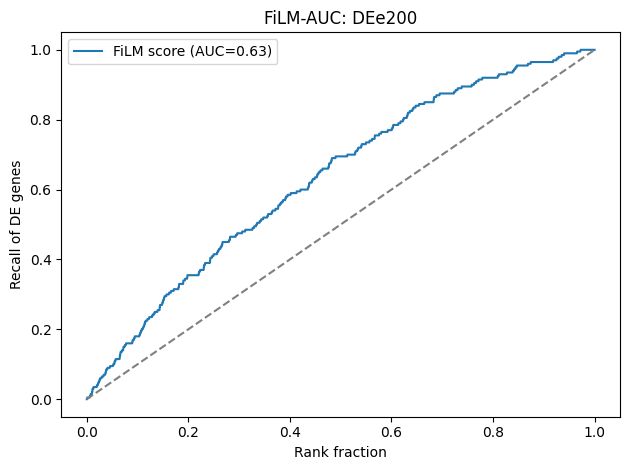

In [49]:

plt.plot(x, y, label=f"FiLM score (AUC={auc_tx:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of DE genes")
plt.title(f"FiLM-AUC: DEe200")
plt.legend()
plt.tight_layout()
plt.show()

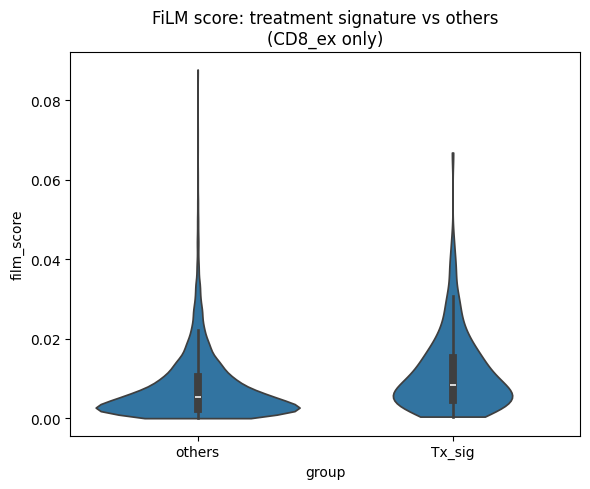

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

fi_plot_tx = fi_tx.copy()
fi_plot_tx["group"] = ["Tx_sig" if g in sig_genes_tx else "others"
                       for g in fi_plot_tx.index]

plt.figure(figsize=(6,5))
sns.violinplot(data=fi_plot_tx, x="group", y="film_score", cut=0, inner="box")
plt.title("FiLM score: treatment signature vs others\n(CD8_ex only)")
plt.tight_layout()
plt.show()


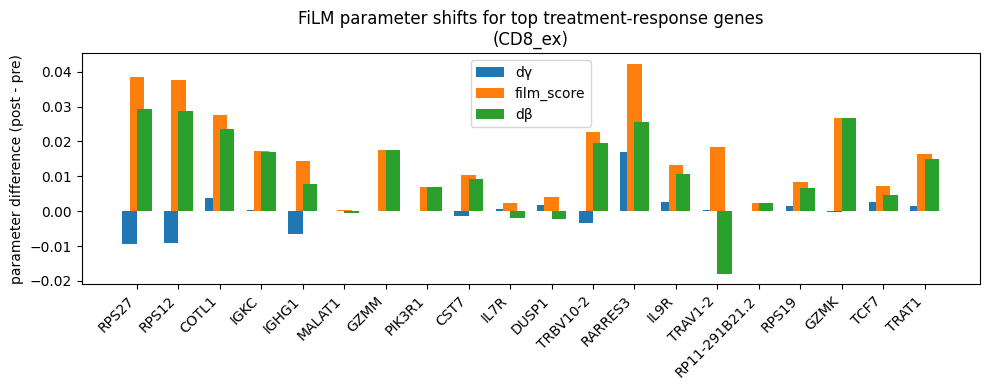

In [51]:
top_tx_genes = sig_genes_tx[:20]  # 你也可以选任意感兴趣的基因

df_small_tx = fi_tx.loc[top_tx_genes, ["d_gamma", "d_beta","film_score"]]

plt.figure(figsize=(10,4))
x = np.arange(len(top_tx_genes))
bar_width = 0.35
plt.bar(x - bar_width/2, df_small_tx["d_gamma"], bar_width, label="dγ")
plt.bar(x , df_small_tx["film_score"],  bar_width, label="film_score")
plt.bar(x + bar_width/2, df_small_tx["d_beta"],  bar_width, label="dβ")

plt.xticks(x, top_tx_genes, rotation=45, ha="right")
plt.ylabel("parameter difference (post - pre)")
plt.title("FiLM parameter shifts for top treatment-response genes\n(CD8_ex)")
plt.legend()
plt.tight_layout()
plt.show()


Hot map of indices